C:\Users\user\AppData\Local\Temp\ipykernel_21388\761429161.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gdf = gdf.applymap(lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else x)



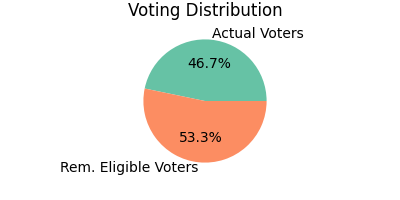
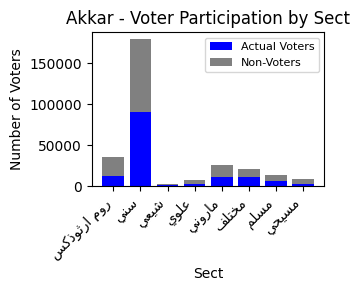
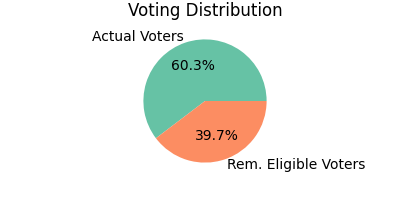
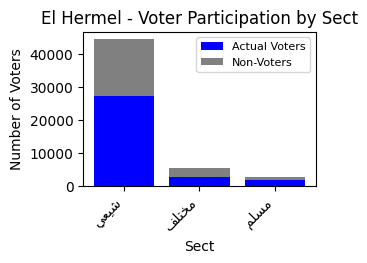
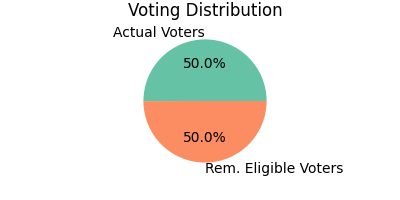
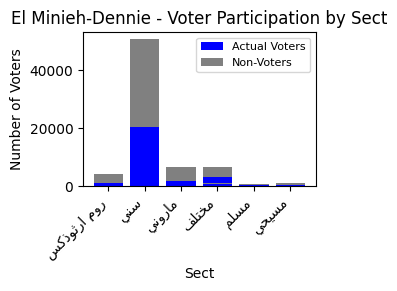
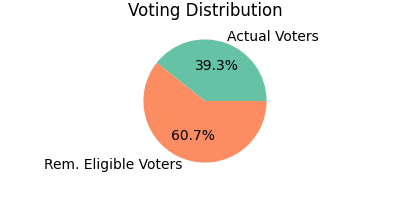
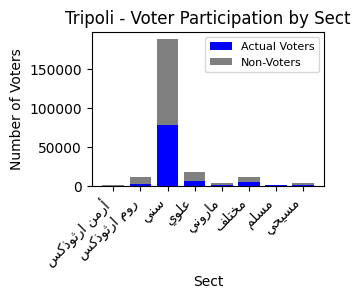
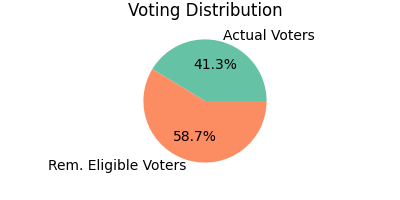
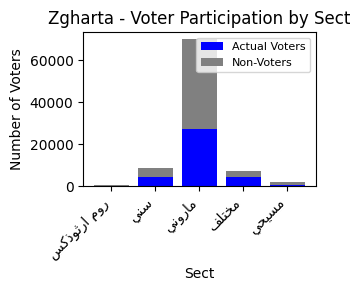
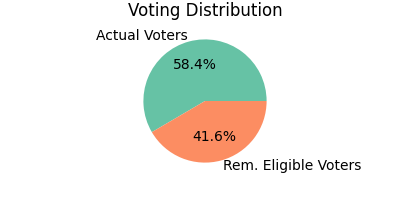
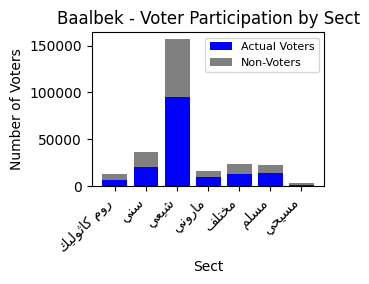
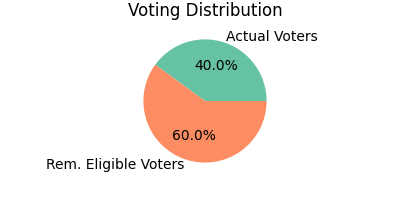
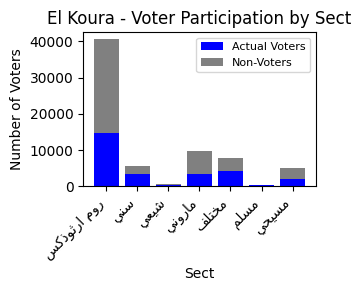
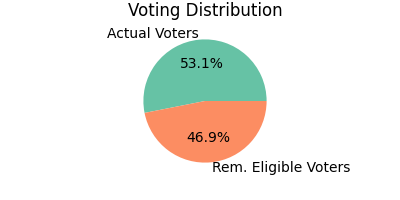
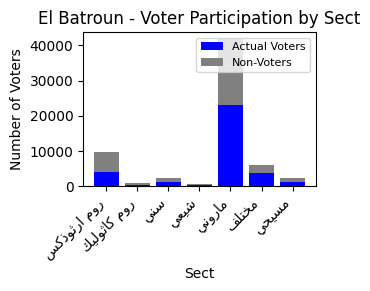
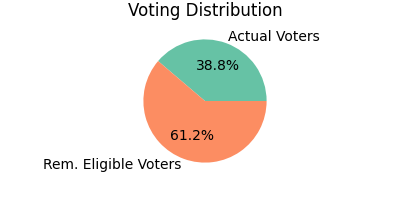
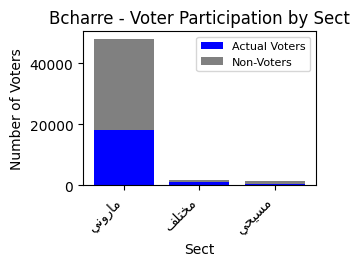
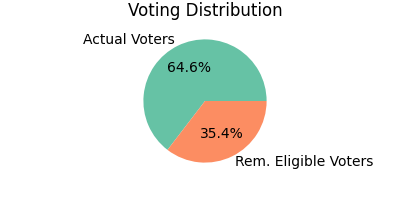
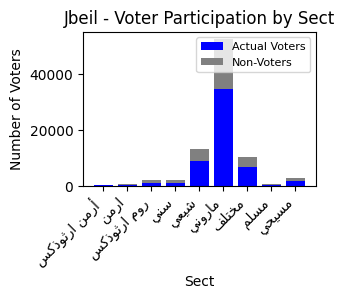
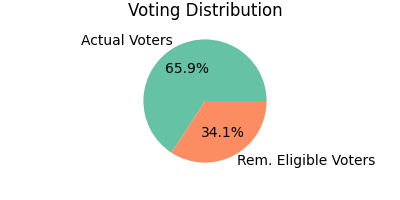
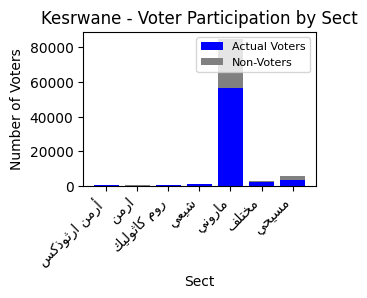
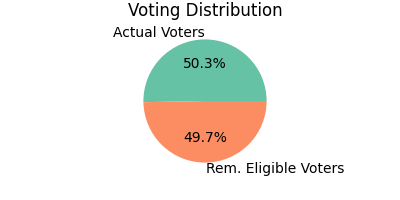
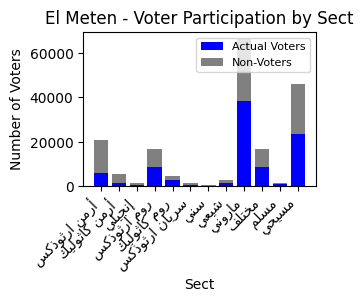
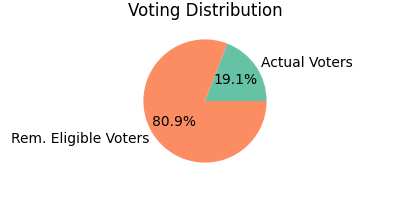
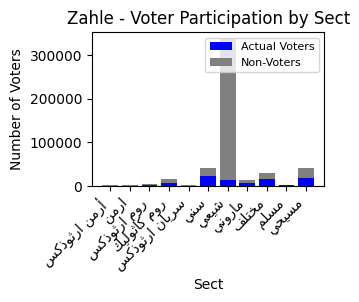
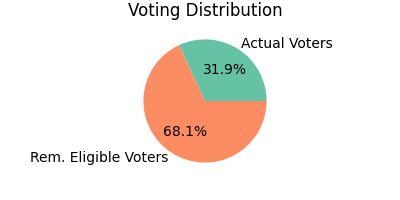
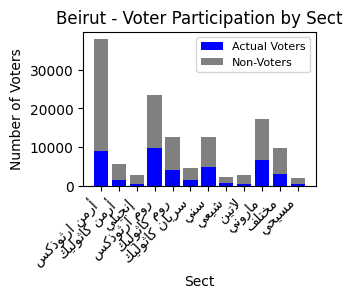
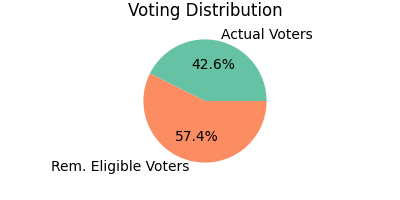
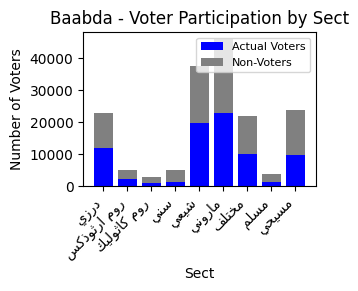
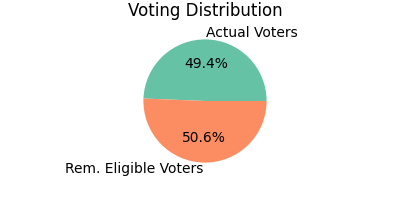
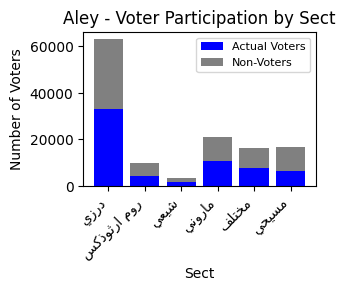
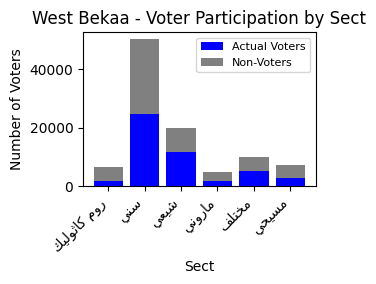
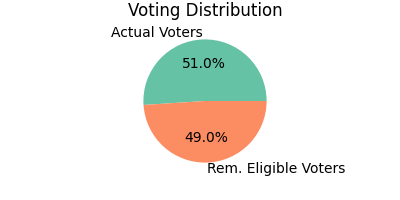
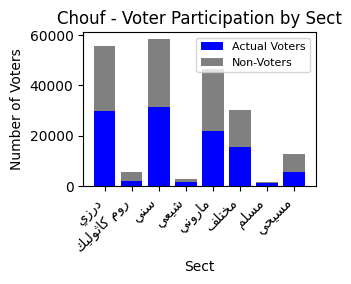
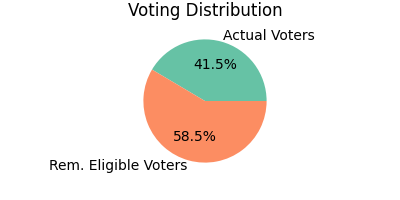
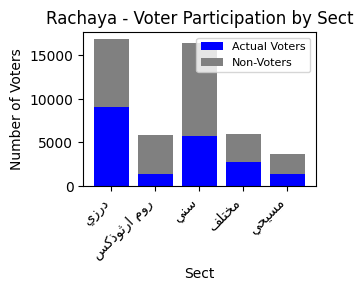
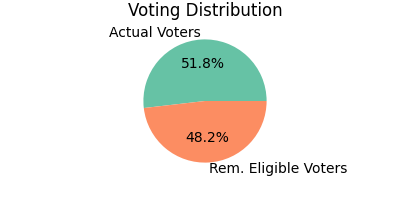
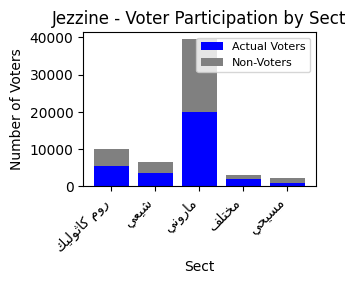
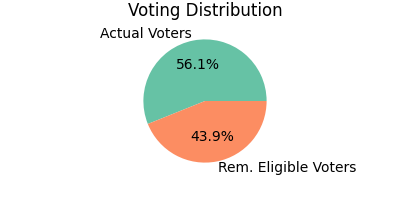
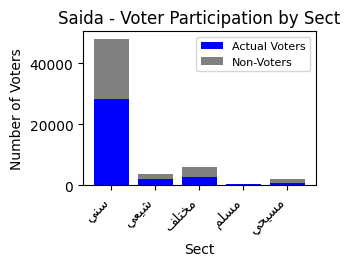
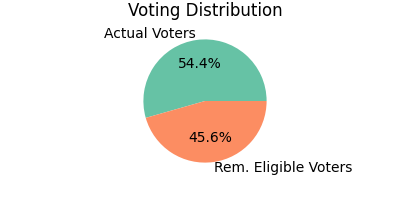
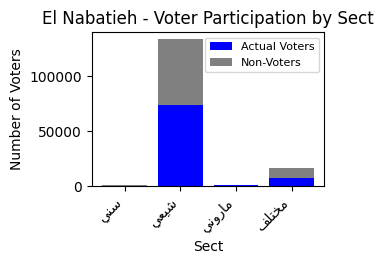
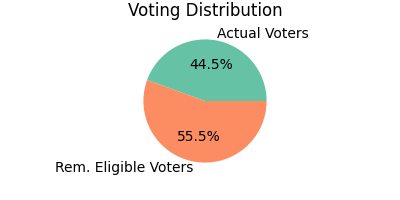
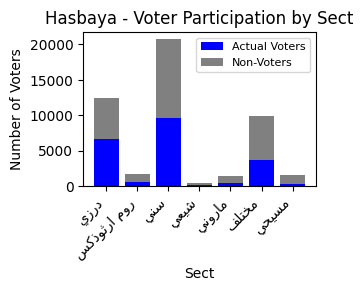
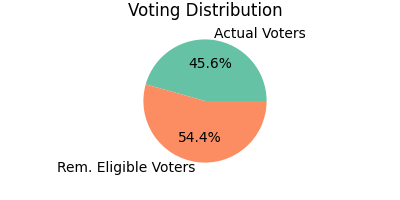
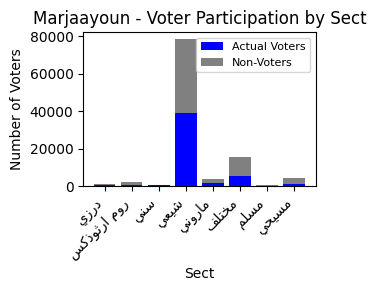
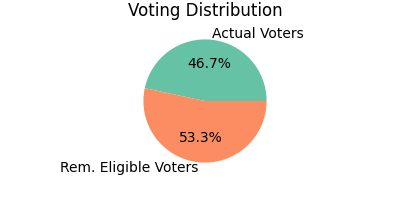
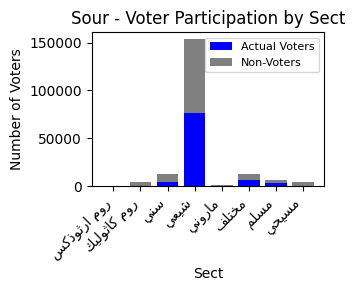
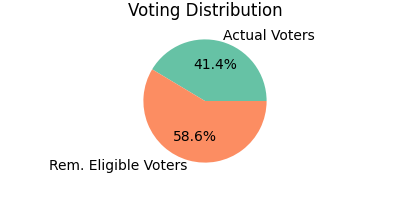
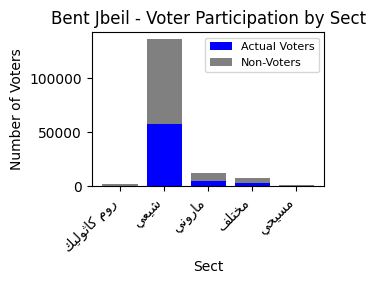

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium.features import GeoJson
from io import BytesIO
import base64
import arabic_reshaper
from bidi.algorithm import get_display


sect_df=pd.read_csv('sect_data.csv')
merged_df=pd.read_csv('district_data.csv')

#put your own path here
shapefile_path = r'C:\Users\user\Desktop\moustapha\lbn_admbnda_adm2_cdr_20200810.shp'

gdf = gpd.read_file(shapefile_path)
gdf = gdf.applymap(lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else x)

geojson_data = gdf.to_json()

merged_df['Ratio'] = merged_df['Actual Voters'] / merged_df['Eligible Voters']
gdf = gdf.merge(merged_df[['area', 'Ratio']], left_on='admin2Name', right_on='area', how='left')

m = folium.Map(location=[33.8547, 35.8623], zoom_start=8)

folium.GeoJson(
    gdf.to_json(),
    name="Districts",
    style_function=lambda feature: {
        'fillColor': '#D2B48C',  
        'color': '#8B4513',  
        'weight': 1,
        'fillOpacity': 1,  
    }
).add_to(m)


label_offsets = {
    'Tripoli': (-0.1, 0.05),    
    'Zgharta': (-0.04, -0.04), 
    'West Bekaa': (-0.05, 0),   
    'Jezzine': (-0.04, 0.06),
    'Marjaayoun': (-0.06, 0),
    'Beirut': (-0.05, 0.05),       
    'Saida': (-0.05, 0),
    'Nabatieh':(-0.03,0)       
}

def create_pie_chart(district_name, eligible_voters, actual_voters):
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.pie(
        [actual_voters, eligible_voters - actual_voters],
        labels=['Actual Voters', 'Rem. Eligible Voters'],
        autopct='%1.1f%%',
        colors=['#66c2a5', '#fc8d62']
    )
    ax.set_title(f'Voting Distribution')

    img = BytesIO()
    plt.savefig(img, format='png')
    plt.close(fig)
    img.seek(0)
    img_base64 = base64.b64encode(img.getvalue()).decode('utf-8')
    return f'<img src="data:image/png;base64,{img_base64}">'


def reshape_and_display_arabic(text):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

def create_stacked_bar_chart(district_name, district_data):

    sects = district_data['sect']
    sects= [reshape_and_display_arabic(x) for x in sects]
    eligible_voters = district_data['Eligible Voters']
    actual_voters = district_data['Actual Voters']
    
    non_voters = eligible_voters - actual_voters
    
    fig, ax = plt.subplots(figsize=(3, 2))

    ax.bar(sects, actual_voters, color='b', label='Actual Voters')
    ax.bar(sects, non_voters, bottom=actual_voters, color='gray', label='Non-Voters')
    
    ax.set_xlabel('Sect')
    ax.set_ylabel('Number of Voters')
    ax.set_title(f'{district_name} - Voter Participation by Sect')
    ax.legend(loc='upper right', prop={'size':8})
    
    plt.xticks(rotation=45, ha='right')
    
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    
    img_html = f'<img src="data:image/png;base64,{img_base64}" alt="Bar Chart for {district_name}">'
    
    plt.close(fig)

    return img_html

for _, row in gdf.iterrows():

    centroid = row.geometry.centroid
    district_name = row["admin2Name"]

    offset_x, offset_y = 0, 0

    #apply custom offsets for district names
    if district_name in label_offsets:
        offset_x, offset_y = label_offsets[district_name]


    district_data = merged_df[merged_df['area'] == district_name]
    sect_data=sect_df[sect_df['district']==district_name]

    if not district_data.empty:
        eligible_voters = district_data['Eligible Voters'].values[0]
        actual_voters = district_data['Actual Voters'].values[0]
        img_html = create_pie_chart(district_name, eligible_voters, actual_voters)
        
    else:
        img_html = f'<div>No data available for pie chart {district_name}</div>'
    
    if not sect_data.empty:    
        bar_html = create_stacked_bar_chart(district_name, sect_data)
    else: 
        bar_html =  f'<div>No data available for stacked bar {district_name}</div>'
    
    combined_html = f'''
        <div style="display: flex; justify-content: space-between;">
            <div style="flex: 1; margin-right: 10px;">
                {img_html}
            </div>
            <div style="flex: 1; margin-left: 10px;">
                {bar_html}
            </div>
        </div>
        '''
        
    
    
    popup = folium.Popup(html=combined_html)

    marker = folium.Marker(
        location=[centroid.y + offset_y, centroid.x + offset_x],
        icon=folium.DivIcon(html=f'''
            <div style="font-size: 7pt; color: black;" class="district-label">
                {district_name.removeprefix('El ')}
            </div>
        ''')
    )
    marker.add_child(popup)  

    marker.add_to(m)


m

